In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import skimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
model = torchvision.models.vgg16(pretrained=True).eval()
sumie.utils.remove_inplace(model)
model.features[30] = torch.nn.AdaptiveMaxPool2d((7,7))
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

100%|██████████| 400/400 [01:58<00:00,  1.48it/s]


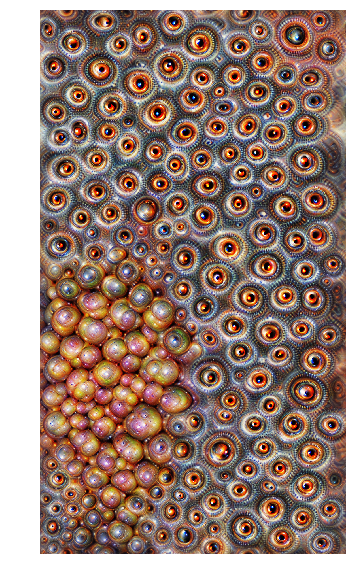

In [6]:
def change_scale(opt, i):
    if i % 150 == 0:
        opt.image.transforms[1].factor *= 2 
        
im = sumie.Image((1080, 1920), param='fft', transforms=[
                    sumie.transforms.PositionJitter(8),
                    sumie.transforms.Interpolate(0.125/2),
                    sumie.transforms.PositionJitter(4),
                    sumie.transforms.Normalise(),
              ]
            )

device = 'cuda'
im.to(device)
model.to(device)
channel = sumie.objectives.ConvChannel(model.features[28], 0, func=torch.max)
obj2 = sumie.objectives.ConvChannel(model.features[10], 0, func=torch.std)
combined = sumie.objectives.Composite([channel, obj2], [1, 10])
dream = sumie.objectives.DeepDream(model.features[21])
opt = sumie.Optimiser(im, model.features, dream)
opt.add_callback(change_scale)
#opt.add_callback(change_combined)

opt.run(iterations=400, progress=True, lr=0.025, output='tmp', output_skip=5)
sumie.vis.show(im.get_image(), figsize=(10,10))

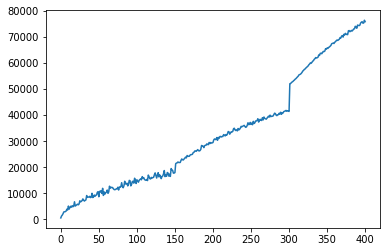

In [4]:
plt.plot([x.item() for x in opt.history])

In [5]:
for child in opt.objective.children:
    print(child.objective)


AttributeError: 'DeepDream' object has no attribute 'children'

In [ ]:
 opt.image.transforms[1].factor

In [ ]:
HTML(anim.to_html5_video())